# Predict GDP of Canada  

<hr>

## Source of data

The 
<a href='https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=CA'>source</a> 
of the data used here is the World Bank national accounts data, and OECD National Accounts data files.

## GDP (current US$) - Canada

GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used.

## What is in this notebook?

Here I have created a Regression model from scratch just using numpy module and trained the model to predict GDP (in US$) of Canada.

<hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv')
df.head()

,year,per capita income (US$)
0,1970,3399.299037
1,1971,3768.297935
2,1972,4251.175484
3,1973,4804.463248
4,1974,5576.514583


In [2]:
df.describe()

,year,per capita income (US$)
count,47.000000,47.000000
mean,1993.000000,18920.137063
std,13.711309,12034.679438
min,1970.000000,3399.299037
25%,1981.500000,9526.914515
50%,1993.000000,16426.725480
75%,2004.500000,27458.601420
max,2016.000000,42676.468370


<hr>

## Data Analysis

year                       0.943884
per capita income (US$)    1.000000
Name: per capita income (US$), dtype: float64


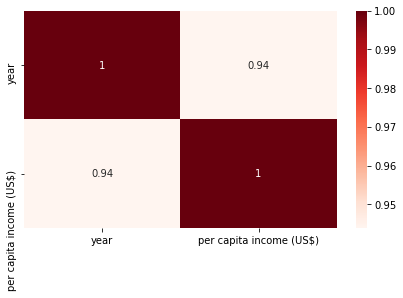

In [3]:
print(df.corr()['per capita income (US$)'].sort_values())

# Using Pearson Correlation
plt.figure(figsize=(7,4))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### There is a high correlation between 'year' and 'per capita income (US$)'

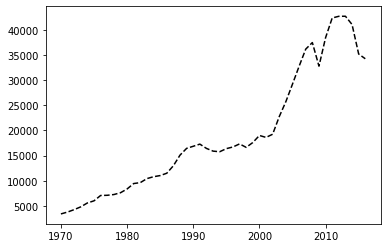

In [4]:
plt.plot(df[['year']], df[['per capita income (US$)']], color='k', linestyle='--')

<hr>

## Creating Model

#### Splitting the dataset

Since per capita income (US$) is increasing slowly in the beginning and between 2000 and 2010 it increased rapidly, so we have to suffle the dataset so that we can get increasing trend of per capita income correctly.

In [5]:
# Shuffling the dataset
df = df.sample(frac=1, random_state=3)

In [6]:
_feature = 'year'
_target = 'per capita income (US$)'

train_dataset = df[:35]
X_train = np.array(train_dataset[_feature]).reshape(-1, 1)
ones = np.array([1 for _ in range(len(X_train))]).reshape(-1, 1) 
X_train = np.concatenate([ones, X_train], axis=1)

y_train = np.array(train_dataset[_target]).reshape(-1, 1)

test_dataset = df[36:47]
X_test = np.array(test_dataset[_feature]).reshape(-1, 1)
ones = np.array([1 for _ in range(len(X_test))]).reshape(-1, 1) 
X_test = np.concatenate([ones, X_test], axis=1)

y_test = np.array(test_dataset[_target]).reshape(-1, 1)

#### Feature Scaling

In [7]:
def _normalize(X):
    # Not normalizing 1's (constant term)
    X_ones = np.ones((len(X), 1)).reshape(1, -1)
    X = X[:, 1:]
    
    # Calculating mean along each column(axis=0)
    _mean = np.mean(X, axis=0)

    # Calculating standard deviation along each column(axis=0)
    _std = np.std(X, axis=0)

    # Calculating Z-score
    z_score = np.divide((X - _mean), _std)
    
    X = np.concatenate((X_ones.T, z_score), axis=1)
    
    return X

X_train = _normalize(X_train)
X_test = _normalize(X_test)

In [8]:
X_train[:5]

array([[ 1.        ,  0.86063578],
       [ 1.        ,  1.53334117],
       [ 1.        , -0.41002995],
       [ 1.        , -0.03630474],
       [ 1.        ,  0.26267544]])

#### Hypothesis

In [9]:
def hypothesis(X, theta):
    return np.matmul(X, theta)

#### Cost Function

In [10]:
def cost(X, y, theta):
    # Lenght of our samples set, X
    m = len(X)
    h = hypothesis(X, theta)

    # mean-square-error
    sqr_error = (h - y) ** 2

    # Cost
    J = (1 / (2 * m)) * sum(sqr_error)[0]
    return J

#### Gradient Descent

In [11]:
def gradient_descent(X, y, theta, alpha, _lambda, num_of_iters):
    # Lenght of our samples set, X
    m = len(X)

    # Initializing column vector, J_history where all elements assigned to 0,
    # while iterating we will fill these values with those iterations cost function's value
    J_history = np.zeros((num_of_iters, 1))

    # Gradient Descent Algorithm Implementation
    for i in range(num_of_iters):
        h = hypothesis(X, theta)

        # Regularization parameter
        regularization_param = 1 - alpha * _lambda / m

        # Regularizing all coefficients. This vectorized version of gradient descent
        tmp_1 = theta * regularization_param - ((alpha / m) * (np.matmul((h - y).T, X)).T)

        # We should NOT regularize the parameter theta_zero
        tmp_2 = theta[0] - ((alpha / m) * (np.matmul((h - y).T, X[:, 0])).T)

        theta = tmp_1
        theta[0] = tmp_2

        J_history[i] = cost(X, y, theta)

    return (theta, J_history)

#### Normal Equation

In [12]:
def normal_equation(X, y, _lambda):
    # Number of rows
    n = len(X[0])

    # Creating a identity matrix whose 0th row's 0th element is 0
    L = np.identity(n)
    L[0][0] = 0

    # Regularization parameter
    regularization_param = _lambda * L

    # Matrix multiplication of X transpose and y
    a = np.matmul(X.T, y)

    # Matrix multiplication of X transpose and X
    b = np.matmul(X.T, X)

    # Adding the regularization parameter
    c = b + regularization_param

    # Taking inverse of matrix b
    d = np.linalg.pinv(c)

    # Matrix multiplication of c transpose and a
    theta = np.matmul(d, a)

    return theta

#### Using Gradient Descent to get best parameters

In [13]:
theta = np.array([[0], [0]])

alpha = 0.5
_lambda = 0
num_of_iters = 24

theta, J_train_history = gradient_descent(X_train, y_train, theta, alpha, _lambda, num_of_iters)

coefficient = theta[1:]
intercept = theta[0]

print("Coefficient: ", coefficient)
print("Intercept: ", intercept)

print()

for idx, cost in enumerate(J_train_history):
    print(idx, cost)

Coefficient:  [[10890.83448823]]
Intercept:  [18918.97339634]

0 [66654583.85182209]
1 [21979156.94282467]
2 [10810300.21557534]
3 [8018086.03376301]
4 [7320032.48830994]
5 [7145519.10194667]
6 [7101890.75535585]
7 [7090983.66870815]
8 [7088256.89704622]
9 [7087575.20413074]
10 [7087404.78090187]
11 [7087362.17509465]
12 [7087351.52364285]
13 [7087348.8607799]
14 [7087348.19506416]
15 [7087348.02863522]
16 [7087347.98702799]
17 [7087347.97662618]
18 [7087347.97402573]
19 [7087347.97337562]
20 [7087347.97321309]
21 [7087347.97317246]
22 [7087347.9731623]
23 [7087347.97315976]


#### Using Normal Equation to get best parameters

In [14]:
_lambda = 0
norm_eq_theta = normal_equation(X_train, y_train, _lambda)

print("Coefficient: ", norm_eq_theta[1:])
print("Intercept: ", norm_eq_theta[0])

Coefficient:  [[10890.83513738]]
Intercept:  [18918.974524]


#### Optimal Parameters

In [15]:
print("Coefficient: ", coefficient)
print("Intercept: ", intercept)

Coefficient:  [[10890.83448823]]
Intercept:  [18918.97339634]


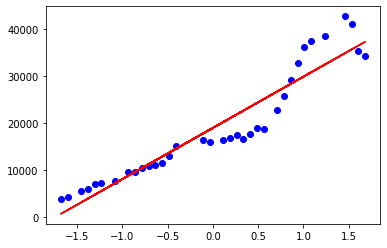

In [16]:
X = np.array([X_train[i][1] for i in range(len(X_train))]).reshape(-1, 1)

plt.scatter(X, y_train,  color='blue')
plt.plot(X, coefficient*X + intercept, '-r')

#### Plotting the cost function history

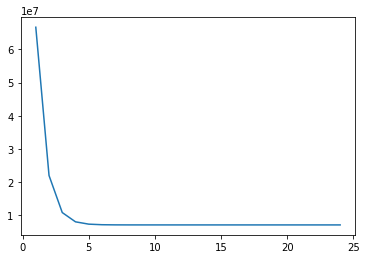

In [17]:
_size = [i for i in range(1, 25)]
plt.plot(_size, J_train_history)

#### Predicting

In [18]:
y_test_pred = hypothesis(X_test, theta)
y_test_pred

array([[26576.30400518],
       [33284.93878637],
       [31794.13105722],
       [10177.41898448],
       [16886.05376568],
       [18376.86149483],
       [ 2723.38033871],
       [ 8686.61125533],
       [ 4959.59193244],
       [20613.07308856],
       [34030.34265095]])

In [19]:
y_test

array([[19232.17556 ],
       [42334.71121 ],
       [32755.17682 ],
       [ 8355.96812 ],
       [16426.72548 ],
       [17266.09769 ],
       [ 3399.299037],
       [ 7247.967035],
       [ 4804.463248],
       [15755.82027 ],
       [42665.25597 ]])

#### Evaluating Model

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# *** Out-Of-Sample Forecast ***

# To see how our model performs on data that model has NOT seen

rms_error = mean_squared_error(y_test, y_test_pred, squared=False)
r2_score_value = r2_score(y_test, y_test_pred)

print(f"Root mean squared error: {rms_error}")
print(f"R2-score: {r2_score_value}")

Root mean squared error: 4692.604777847343
R2-score: 0.8794970759997227


#### Visualizing our prediction against actual values

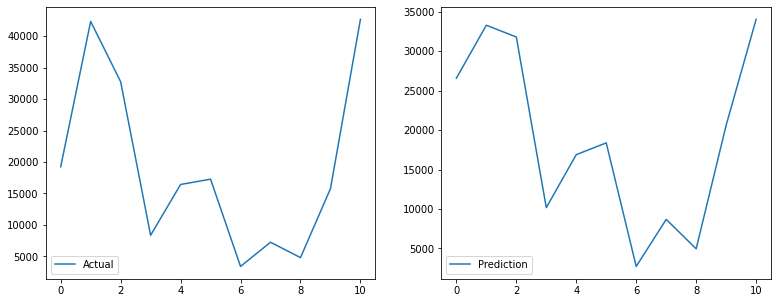

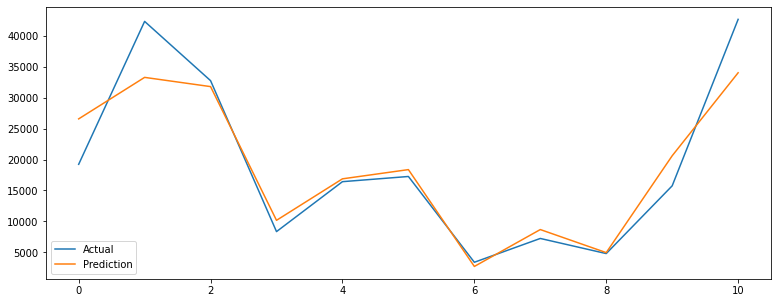

In [22]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test)), y_test, label='Actual')
ax2.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test)), y_test, label='Actual')
ax3.plot(np.arange(len(y_test_pred)), y_test_pred, label='Prediction')

ax3.legend()

<hr>